In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import json

from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import playercareerstats

In [4]:
d = {"col_{}".format(i):list(np.random.randint(0,100,200)) for i in range(10)}

pd.DataFrame(d).to_json("kk.json",orient="records")

# Collecting Data

## Collecting champion teams for seasons

In [3]:
chDict = {"year":[], "season":[], "team_id":[], "team_abv":[], "team_name":[]}
for i in tqdm(range(1960,2023)):
    df = leaguegamelog.LeagueGameLog(season_type_all_star="Playoffs", season=str(i), timeout=120)
    s = "{}-{}".format(i, str(i+1)[-2:])
    ee = df.get_data_frames()[0]
    ch = ee[ee["WL"] == "W"].sort_values("GAME_DATE")["TEAM_NAME"].iloc[-1]
    chDict["year"].append(i)
    chDict["season"].append(s)
    chDict["team_id"].append(ee[ee["TEAM_NAME"] == ch]["TEAM_ID"].iloc[0])
    chDict["team_abv"].append(ee[ee["TEAM_NAME"] == ch]["TEAM_ABBREVIATION"].iloc[0])
    chDict["team_name"].append(ch)
    
    time.sleep(10)
    
chDf = pd.DataFrame(chDict)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [12:19<00:00, 11.73s/it]


In [4]:
chDf.to_csv("chDf.csv", index=False)

## Collecting the team rosters for the championship season

In [5]:
allChPlayer = pd.DataFrame()
for i in tqdm(chDf.index):
    oneCh = commonteamroster.CommonTeamRoster(team_id=chDf.loc[i, "team_id"], season=chDf.loc[i,"season"], timeout=120)
    allChPlayer = pd.concat([allChPlayer, oneCh.get_data_frames()[0]])
    
    time.sleep(10)
    
allChPlayer["SEASON_ID"] = allChPlayer["SEASON"].apply(lambda x: "{}-{}".format(x, str(int(x)+1)[-2:]))

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [11:55<00:00, 11.36s/it]


In [6]:
allChPlayer.to_csv("allChPlayer.csv", index = False)

## Collecting number of rings, minutes, games played in the winning seasons per players

In [22]:
### Sokáig fut!!! ###

ringMinDict = {"name":[], "rings":[], "min":[], "game":[]}

pIDList = list(allChPlayer["PLAYER_ID"].unique())

for i in tqdm(pIDList):
    if pIDList.index(i) in np.arange(50,550,50):
        pd.DataFrame(ringMinDict).to_csv("ringMinDf_{}.csv".format(pIDList.index(i)), index=False)
    
    oneP_allChSeason = allChPlayer[allChPlayer["PLAYER_ID"] == i]["SEASON_ID"].to_list()
    
    ww = playercareerstats.PlayerCareerStats(player_id=i, per_mode36="Totals", timeout=120)
    pfAll = ww.get_data_frames()[2]
    regAll = ww.get_data_frames()[0]
    
    if regAll["TEAM_ABBREVIATION"].isin(["TOT"]).sum() > 0:
        for dupSeason in regAll[regAll["TEAM_ABBREVIATION"] == "TOT"]["SEASON_ID"].unique():
            regAll.drop(regAll[(regAll["SEASON_ID"] == dupSeason) & (regAll["TEAM_ABBREVIATION"] != "TOT")].index, inplace = True)
    
    regpf = pd.concat([pfAll[pfAll["SEASON_ID"].isin(oneP_allChSeason)], regAll[regAll["SEASON_ID"].isin(oneP_allChSeason)]])
    
    ringMinDict["name"].append(allChPlayer[allChPlayer["PLAYER_ID"] == i]["PLAYER"].iloc[0])
    ringMinDict["rings"].append(len(oneP_allChSeason))
    ringMinDict["min"].append(regpf["MIN"].sum())
    ringMinDict["game"].append(regpf["GP"].sum())
    
    time.sleep(10)
    
ringMinDf = pd.DataFrame(ringMinDict)

100%|██████████████████████████████████████████████████████████████████████████████| 548/548 [1:59:12<00:00, 13.05s/it]


In [27]:
ringMinDf["min/ring"] = ringMinDf["min"] / ringMinDf["rings"]
ringMinDf["game/rings"] = ringMinDf["game"] / ringMinDf["rings"]
ringMinDf["min/game"] = ringMinDf["min"] / ringMinDf["game"]

ringMinDf.to_csv("ringMinDf.csv", index=False)
ringMinDf.to_json("ringMinDf.json", orient="records")

# Analysis

In [10]:
chDf

,year,season,team_id,team_abv,team_name
0,1960,1960-61,1610612738,BOS,Boston Celtics
1,1961,1961-62,1610612738,BOS,Boston Celtics
2,1962,1962-63,1610612738,BOS,Boston Celtics
3,1963,1963-64,1610612738,BOS,Boston Celtics
4,1964,1964-65,1610612738,BOS,Boston Celtics
...,...,...,...,...,...
58,2018,2018-19,1610612761,TOR,Toronto Raptors
59,2019,2019-20,1610612747,LAL,Los Angeles Lakers
60,2020,2020-21,1610612749,MIL,Milwaukee Bucks
61,2021,2021-22,1610612744,GSW,Golden State Warriors


In [9]:
allChPlayer["PLAYER"].value_counts().head(30)

Bill Russell           8
Sam Jones              8
Thomas Sanders         8
John Havlicek          8
Robert Horry           7
Kareem Abdul-Jabbar    6
K.C. Jones             6
Scottie Pippen         6
Michael Jordan         6
Don Nelson             5
Magic Johnson          5
Michael Cooper         5
Steve Kerr             5
Dennis Rodman          5
Ron Harper             5
Derek Fisher           5
Larry Siegfried        5
Kobe Bryant            5
Tom Heinsohn           5
Tim Duncan             5
Robert Parish          4
Andre Iguodala         4
Jim Loscutoff          4
Shaquille O'Neal       4
Will Perdue            4
Frank Ramsey           4
Stephen Curry          4
Draymond Green         4
Horace Grant           4
Klay Thompson          4
Name: PLAYER, dtype: int64

In [68]:
allChPlayer["PLAYER"].value_counts().value_counts()

1    392
2     84
3     36
4     16
5     11
8      4
6      4
7      1
Name: PLAYER, dtype: int64

In [203]:
ringMinDf.sort_values("rings", ascending = False)

,name,rings,min,game
8,Bill Russell,8,32244.0,734
5,Sam Jones,8,22252.0,711
9,Thomas Sanders,8,19132.0,725
13,John Havlicek,8,25610.0,742
263,Robert Horry,7,16678.0,668
...,...,...,...,...
191,Mark McNamara,1,184.0,38
190,Moses Malone,1,3456.0,91
189,Bobby Jones,1,2073.0,86
188,Reggie Johnson,1,1573.0,84


In [205]:
ringMinDf.sort_values("min/ring", ascending = False)

,name,rings,min,game,min/ring,game/ring,min/game
28,Wilt Chamberlain,2,8572.0,193,4286.0,96.50,44.414508
137,Elvin Hayes,1,4114.0,102,4114.0,102.00,40.333333
8,Bill Russell,8,32244.0,734,4030.5,91.75,43.929155
100,Jojo White,2,8051.0,200,4025.5,100.00,40.255000
266,Hakeem Olajuwon,2,8048.0,197,4024.0,98.50,40.852792
...,...,...,...,...,...,...,...
90,Luke Rackley,1,2.0,1,2.0,1.00,2.000000
318,Erick Barkley,1,0.0,0,0.0,0.00,NaN
316,Duane Causwell,1,0.0,0,0.0,0.00,NaN
542,Collin Gillespie,1,0.0,0,0.0,0.00,NaN


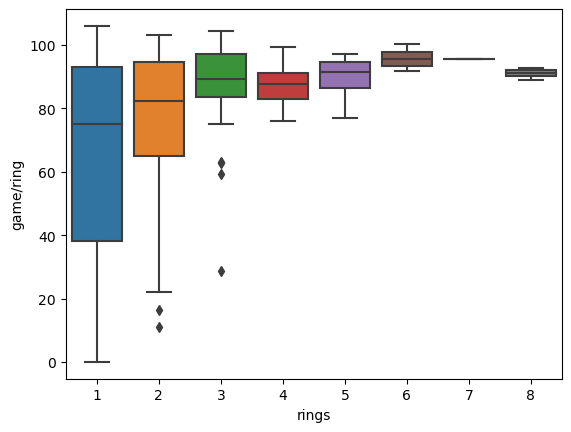

C:\Users\Peter\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 32.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Peter\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


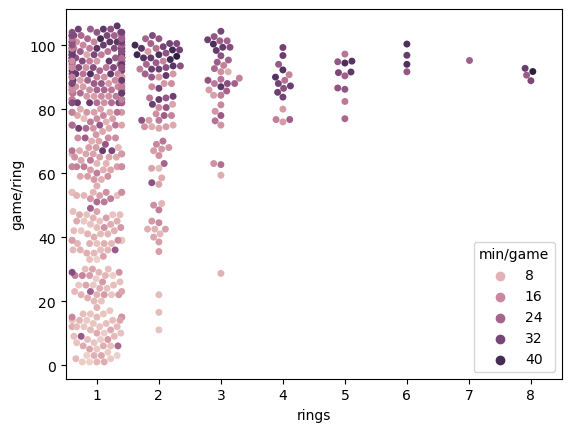

In [228]:
sns.boxplot(data=ringMinDf, x = "rings", y = "game/ring")
plt.show()

f1 = sns.swarmplot(data=ringMinDf, x = "rings", y = "game/ring", hue = "min/game")
cbar = plt.colorbar
plt.show()

In [254]:
ringMinDf.sort_values(["rings", "min/game"], ascending = False).groupby("rings", as_index = False).head(5).set_index(["rings", "name"])

min  game     min/ring   game/ring   min/game
rings name                                                                  
8     Bill Russell         32244.0   734  4030.500000   91.750000  43.929155
      John Havlicek        25610.0   742  3201.250000   92.750000  34.514825
      Sam Jones            22252.0   711  2781.500000   88.875000  31.296765
      Thomas Sanders       19132.0   725  2391.500000   90.625000  26.388966
7     Robert Horry         16678.0   668  2382.571429   95.428571  24.967066
6     Michael Jordan       23384.0   602  3897.333333  100.333333  38.843854
      Scottie Pippen       21595.0   564  3599.166667   94.000000  38.289007
      Kareem Abdul-Jabbar  20062.0   581  3343.666667   96.833333  34.530120
      K.C. Jones           15110.0   550  2518.333333   91.666667  27.472727
5     Kobe Bryant          18421.0   472  3684.200000   94.400000  39.027542
      Magic Johnson        17646.0   475  3529.200000   95.000000  37.149474
      Tim Duncan           16341.0   458  3268.200000   91.600000  35.679039
      Dennis Rodman        14325.0   457  2865.000000   91.400000  31.345733
      Tom Heinsohn         12122.0   431  2424.400000   86.200000  28.125290
4     Shaquille O'Neal     13525.0   360  3381.250000   90.000000  37.569444
      LeBron James         13755.0   369  3438.750000   92.250000  37.276423
      Horace Grant         13230.0   387  3307.500000   96.750000  34.186047
      Stephen Curry        11840.0   349  2960.000000   87.250000  33.925501
      Klay Thompson        11492.0   341  2873.000000   85.250000  33.700880
3     Larry Bird           11861.0   301  3953.666667  100.333333  39.405316
      Dwyane Wade           9556.0   261  3185.333333   87.000000  36.613027
      Dennis Johnson       10318.0   295  3439.333333   98.333333  34.976271
      James Worthy         10373.0   298  3457.666667   99.333333  34.808725
      Byron Scott          10172.0   305  3390.666667  101.666667  33.350820
2     Wilt Chamberlain      8572.0   193  4286.000000   96.500000  44.414508
      Dave Cowens           8023.0   194  4011.500000   97.000000  41.355670
      Walt Frazier          7820.0   191  3910.000000   95.500000  40.942408
      Hakeem Olajuwon       8048.0   197  4024.000000   98.500000  40.852792
      Jojo White            8051.0   200  4025.500000  100.000000  40.255000
1     Rick Barry            3961.0    97  3961.000000   97.000000  40.835052
      Elvin Hayes           4114.0   102  4114.000000  102.000000  40.333333
      Hal Greer             3774.0    95  3774.000000   95.000000  39.726316
      Oscar Robertson       3714.0    95  3714.000000   95.000000  39.094737
      Jerry West            3581.0    92  3581.000000   92.000000  38.923913

In [253]:
ringMinDf.sort_values(["rings", "game"], ascending = False).groupby("rings", as_index = False).head(5).set_index(["rings", "name"])

min  game     min/ring   game/ring   min/game
rings name                                                                  
8     John Havlicek        25610.0   742  3201.250000   92.750000  34.514825
      Bill Russell         32244.0   734  4030.500000   91.750000  43.929155
      Thomas Sanders       19132.0   725  2391.500000   90.625000  26.388966
      Sam Jones            22252.0   711  2781.500000   88.875000  31.296765
7     Robert Horry         16678.0   668  2382.571429   95.428571  24.967066
6     Michael Jordan       23384.0   602  3897.333333  100.333333  38.843854
      Kareem Abdul-Jabbar  20062.0   581  3343.666667   96.833333  34.530120
      Scottie Pippen       21595.0   564  3599.166667   94.000000  38.289007
      K.C. Jones           15110.0   550  2518.333333   91.666667  27.472727
5     Don Nelson            9641.0   486  1928.200000   97.200000  19.837449
      Magic Johnson        17646.0   475  3529.200000   95.000000  37.149474
      Michael Cooper       12863.0   474  2572.600000   94.800000  27.137131
      Kobe Bryant          18421.0   472  3684.200000   94.400000  39.027542
      Tim Duncan           16341.0   458  3268.200000   91.600000  35.679039
4     Tony Parker          13146.0   397  3286.500000   99.250000  33.113350
      Horace Grant         13230.0   387  3307.500000   96.750000  34.186047
      Manu Ginobili         9855.0   376  2463.750000   94.000000  26.210106
      LeBron James         13755.0   369  3438.750000   92.250000  37.276423
      Kurt Rambis           6162.0   363  1540.500000   90.750000  16.975207
3     Bruce Bowen           9915.0   313  3305.000000  104.333333  31.677316
      A.C. Green            8465.0   308  2821.666667  102.666667  27.483766
      Byron Scott          10172.0   305  3390.666667  101.666667  33.350820
      B.J. Armstrong        7448.0   304  2482.666667  101.333333  24.500000
      Rick Fox              7612.0   304  2537.333333  101.333333  25.039474
2     Lamar Odom            6303.0   206  3151.500000  103.000000  30.597087
      Mychal Thompson       4913.0   204  2456.500000  102.000000  24.083333
      Kenny Smith           5587.0   204  2793.500000  102.000000  27.387255
      Cedric Maxwell        6582.0   201  3291.000000  100.500000  32.746269
      Vinnie Johnson        4880.0   201  2440.000000  100.500000  24.278607
1     Paul Pierce           3864.0   106  3864.000000  106.000000  36.452830
      Otis Thorpe           3763.0   105  3763.000000  105.000000  35.838095
      Tayshaun Prince       3497.0   105  3497.000000  105.000000  33.304762
      Antoine Walker        3061.0   105  3061.000000  105.000000  29.152381
      Trevor Ariza          2721.0   105  2721.000000  105.000000  25.914286

# Create json formats

In [4]:
chDf = pd.read_csv("../nba_championship_rings/data/chDf.csv").sort_values("year", ascending = False).reset_index(drop = True)

In [5]:
xyCords = [(col,row) for row in range(7) for col in reversed(range(9))]
data = []
for i,val in enumerate(xyCords):
    data.append({
        "x":val[0],
        "y":val[1],
        "size":20,
        "label":chDf.loc[i,"year"],
        "group":chDf.loc[i, "team_abv"],
        "fullname": chDf.loc[i,"team_name"]
    })


In [6]:
chDf["x"] = [i[0] for i in xyCords]
chDf["y"] = [i[1] for i in xyCords]
chDf["size"] = 8

In [8]:
#chDf[["x","y","size","year","team_abv", "team_name"]].rename(columns={"year":"label", "team_abv":"group", "team_name":"fullname"}).to_json("../nba_champion_rings/data/chDf_data.json", orient="records")

In [9]:
allChPlayer = pd.read_csv("../nba_championship_rings/data/allChPlayer.csv")
allChPlayer["ring"] = allChPlayer.groupby("PLAYER_ID")["PLAYER"].transform(lambda x: x.count())
allChPlayer = pd.merge(left = allChPlayer, right=chDf[["team_id", "team_name"]].drop_duplicates("team_id"), left_on=["TeamID"], right_on=["team_id"], how="left")

In [5]:
allChPlayer[allChPlayer["PLAYER"] == "Stephen Curry"]

,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED,SEASON_ID,ring,team_id,team_name
716,1610612744,2014,0,Stephen Curry,Stephen,stephen-curry,30.0,G,6-3,190,"MAR 14, 1988",27.0,5,Davidson,201939,#7 Pick in 2009 Draft,2014-15,4,1610612744,Golden State Warriors
747,1610612744,2016,0,Stephen Curry,Stephen,stephen-curry,30.0,G,6-3,190,"MAR 14, 1988",29.0,7,Davidson,201939,#7 Pick in 2009 Draft,2016-17,4,1610612744,Golden State Warriors
762,1610612744,2017,0,Stephen Curry,Stephen,stephen-curry,30.0,G,6-3,190,"MAR 14, 1988",30.0,8,Davidson,201939,#7 Pick in 2009 Draft,2017-18,4,1610612744,Golden State Warriors
829,1610612744,2021,0,Stephen Curry,Stephen,stephen-curry,30.0,G,6-2,185,"MAR 14, 1988",34.0,12,Davidson,201939,#7 Pick in 2009 Draft,2021-22,4,1610612744,Golden State Warriors


In [8]:
allChPlayer.drop_duplicates("PLAYER")["ring"].value_counts()

1    392
2     84
3     36
4     16
5     11
6      4
8      4
7      1
Name: ring, dtype: int64

In [66]:
# egymás mellet lenne egy barplot és egy scatterplot - a barploton csak az lenne hogy ki hány gyűrűt nyert a scatteren pedig az idő lenne az y tengely és a szin pedig a csapat
## lehetne szűrni az időt és a gyűrűk számát

In [9]:
allChPlayer[["PLAYER", "AGE","SEASON", "ring", "team_name"]].to_json("allChPlayer_data.json", orient="records")

In [10]:
allChPlayer.sort_values("AGE")

,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED,SEASON_ID,ring,team_id,team_name
412,1610612741,1992,0,Corey Williams,Corey,corey-williams,12.0,G,6-3,190,"AUG 08, 1977",15.0,R,Oklahoma State,101258,NaN,1992-93,1,1610612741,Chicago Bulls
556,1610612765,2003,0,Darko Milicic,Darko,darko-milicic,31.0,F-C,7-0,245,"JUN 20, 1985",19.0,R,Hemoform,2545,NaN,2003-04,1,1610612765,Detroit Pistons
785,1610612747,2019,0,Talen Horton-Tucker,Talen,talen-horton-tucker,5.0,G,6-4,234,"NOV 25, 2000",19.0,R,Iowa State,1629659,NaN,2019-20,1,1610612747,Los Angeles Lakers
816,1610612744,2021,0,Jonathan Kuminga,Jonathan,jonathan-kuminga,0.0,F,6-7,225,"OCT 06, 2002",19.0,R,NBA G League Ignite,1630228,#7 Pick in 2021 Draft,2021-22,1,1610612744,Golden State Warriors
239,1610612747,1979,0,Magic Johnson,Magic,magic-johnson,32.0,G,6-9,215,"AUG 14, 1959",20.0,R,Michigan State,77142,NaN,1979-80,5,1610612747,Los Angeles Lakers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,1610612759,2002,0,Kevin Willis,Kevin,kevin-willis,42.0,C,7-0,245,"SEP 06, 1962",40.0,17,Michigan State,788,NaN,2002-03,1,1610612759,San Antonio Spurs
330,1610612747,1987,0,Kareem Abdul-Jabbar,Kareem,kareem-abdul-jabbar,33.0,C,7-2,225,"APR 16, 1947",41.0,18,UCLA,76003,NaN,1987-88,6,1610612747,Los Angeles Lakers
458,1610612741,1996,0,Robert Parish,Robert,robert-parish,0.0,C,7-1,244,"AUG 30, 1953",43.0,20,Centenary-Louisiana,305,NaN,1996-97,4,1610612741,Chicago Bulls
352,1610612765,1988,0,Bill Laimbeer,Bill,bill-laimbeer,40.0,C,6-11,245,"JAN 01, 1900",89.0,8,NaN,100263,NaN,1988-89,2,1610612765,Detroit Pistons


In [72]:
chDf

,year,season,team_id,team_abv,team_name
0,2022,2022-23,1610612743,DEN,Denver Nuggets
1,2021,2021-22,1610612744,GSW,Golden State Warriors
2,2020,2020-21,1610612749,MIL,Milwaukee Bucks
3,2019,2019-20,1610612747,LAL,Los Angeles Lakers
4,2018,2018-19,1610612761,TOR,Toronto Raptors
...,...,...,...,...,...
58,1964,1964-65,1610612738,BOS,Boston Celtics
59,1963,1963-64,1610612738,BOS,Boston Celtics
60,1962,1962-63,1610612738,BOS,Boston Celtics
61,1961,1961-62,1610612738,BOS,Boston Celtics


In [2]:
df = pd.read_csv("../nba_championship_rings/data/ringMinDf.csv")

In [12]:
df[df["rings"] == i]

,name,rings,min,game,min/ring,game/rings,min/game


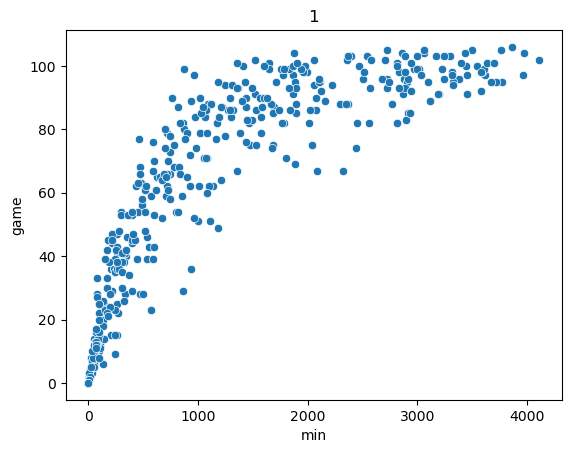

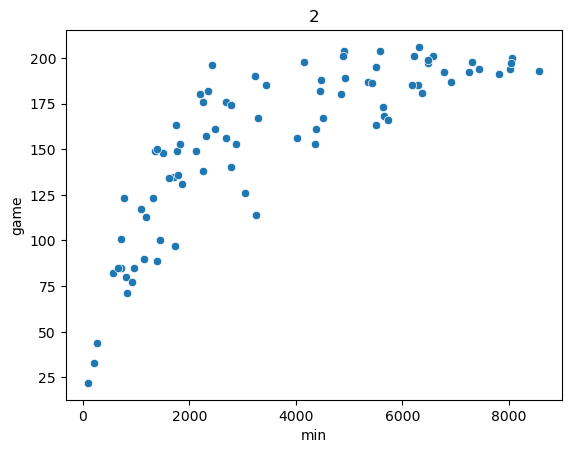

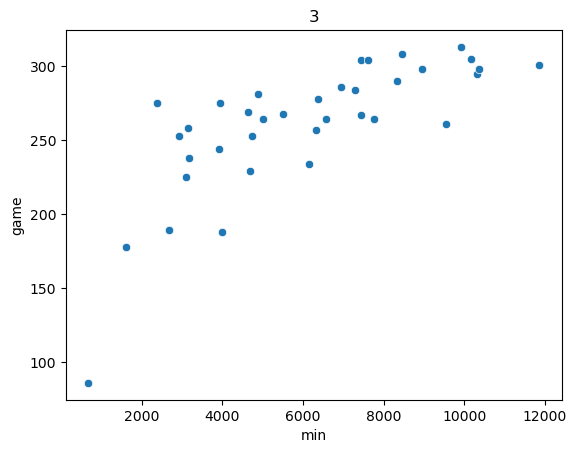

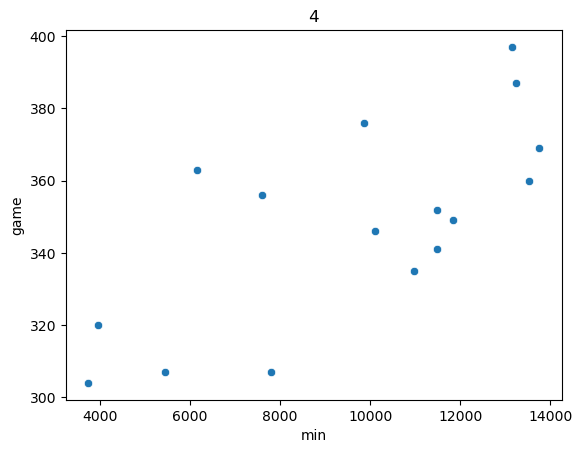

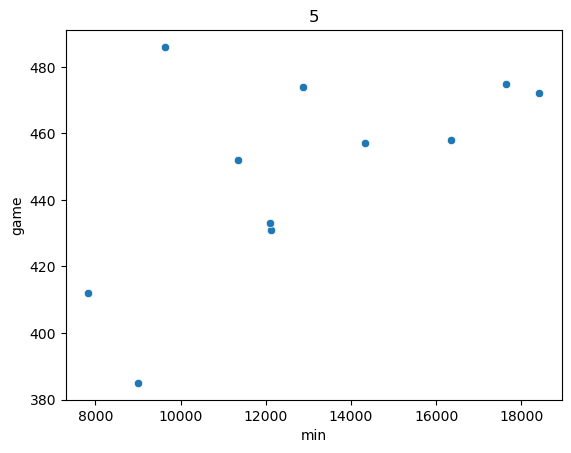

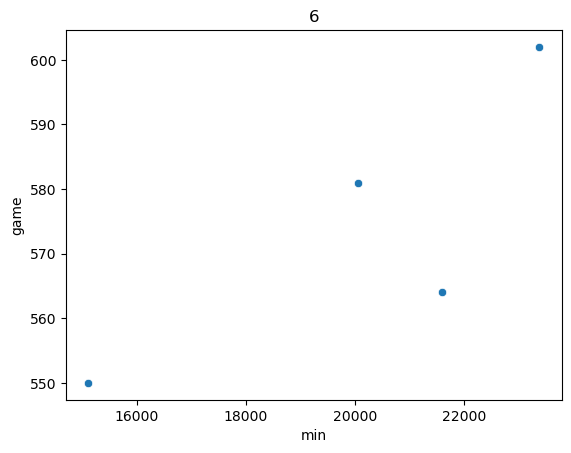

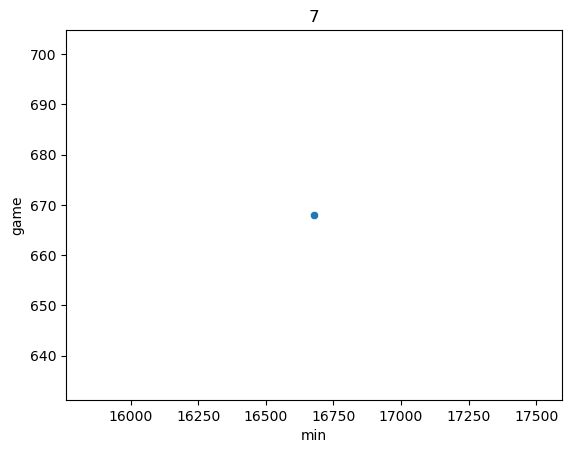

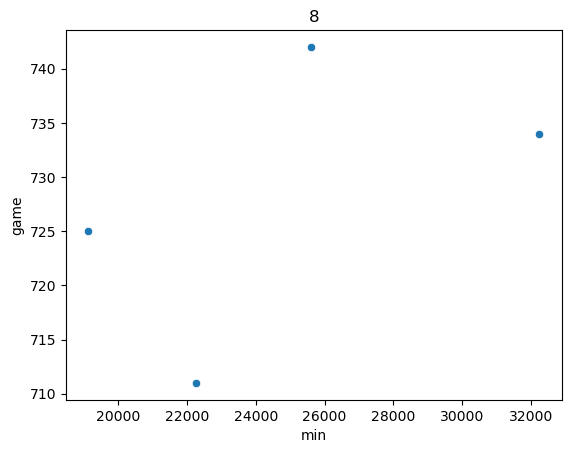

In [6]:
for i in range(1,9):
    sns.scatterplot(data=df[df["rings"] == i], x = "min", y = "game")
    plt.title(i)
    plt.show()

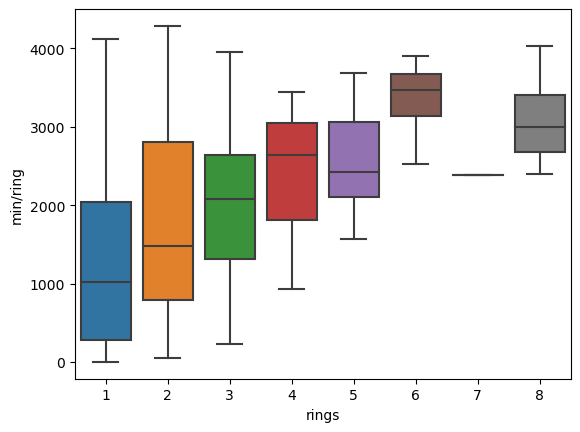

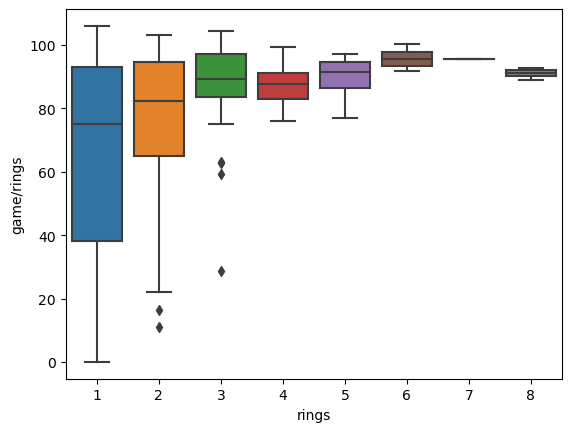

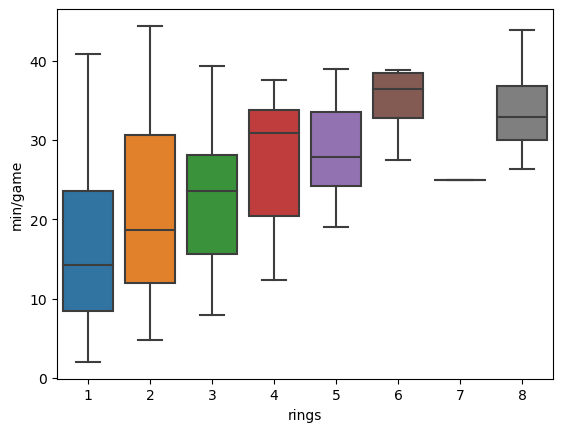

In [4]:
for i in ["min/ring", "game/rings", "min/game"]:
    sns.boxplot(data = df, x = "rings", y = i)
    plt.show()

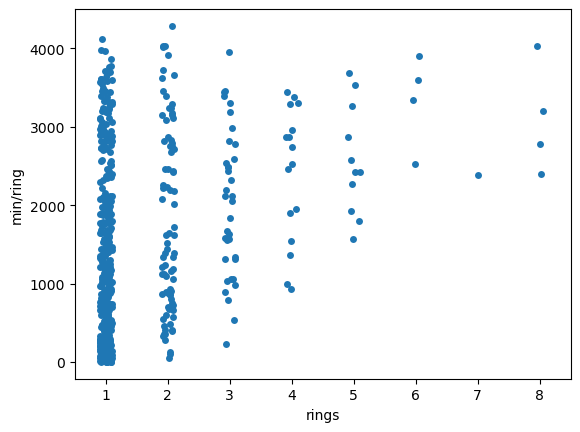

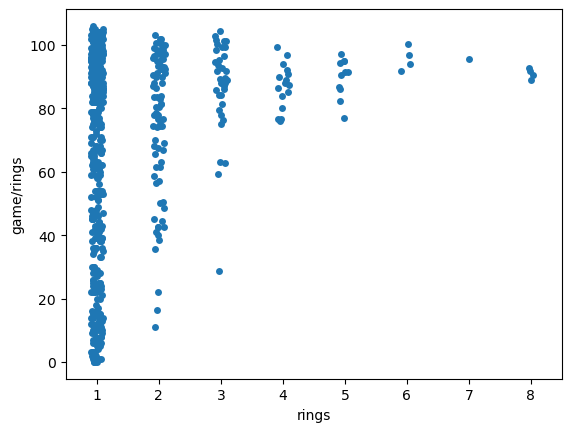

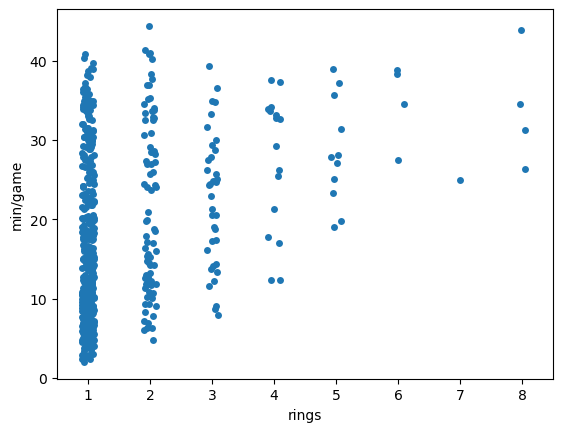

In [10]:
for i in ["min/ring", "game/rings", "min/game"]:
    sns.stripplot(data = df, x = "rings", y = i, dodge=True)
    plt.show()

In [27]:
boxplotData = {}
for i in ["min/rings", "game/rings", "min/game"]:
    boxplotData.update({i:[]})
    for j in range(1,9):
        boxplotData[i].append(df[df["rings"] == j][i].fillna(0).to_list())
        

In [28]:
with open("boxplotData.json", "w") as outfile:
    json.dump(boxplotData, outfile)